# Project: Time Series Analysis

## Project Goal:

Aim of this project is to carry out a short-term temperature forecast.

Outline of the project steps:
- Get and **clean** temperature data from www.ecad.eu (chosen location - Riga, Latvia)
- Build a baseline model - model the **trend** and **seasonality**
- Plot and inspect the different components of a time series
- Model time dependence of the **remainder** using an **autoregressive (AR) model**
- Compare the statistical output of different AR models
- Test the remainder for stationarity

In [2]:
#Import module

import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [3]:
# Set plot size for the images

plt.rcParams["figure.figsize"]=(12,6)

## Step 1 - Load the Data

In [4]:
f = open('../Data/ECA_blended_custom/TG_STAID021960.txt', 'r')
lines=[]
columns = []
n=0
for line in f:
    line = line.strip()
    if n<19:
        pass
#    elif n == 19:
 #       header = line.split()
    else:
        lines 
        lines.append(line)
        columns.append(line.split(","))
    n=n+1

In [5]:
# Create a dataframe with column conent and use the first row for the header
# Explore the dataframe

df = pd.DataFrame(columns)
df.columns = df.iloc[0] 
df = df[1:]
df

,SOUID,DATE,TG,Q_TG
1,105287,19230101,38,0
2,105287,19230102,24,0
3,105287,19230103,4,0
4,105287,19230104,18,0
5,105287,19230105,4,0
...,...,...,...,...
36307,105287,20220527,-9999,9
36308,105287,20220528,-9999,9
36309,105287,20220529,-9999,9
36310,105287,20220530,-9999,9


In [7]:
# Rename the headers
# TG - mean temperature in 0.1ºC (float) / MISSING VALUE CODE IS -9999
# Q_TG - Quality code for TG: 0='valid'; 1='suspect'; 9='missing' (int)
df.columns = ["ID", "Date", "TG", "Q_TG"]

In [8]:
#Format the data in the table and explore dataframe

df["source_identifier"]=pd.to_numeric(df["ID"])
df['Timestamp']=pd.to_datetime(df['Date'])
df["mean_temperture"]=(pd.to_numeric(df["TG"], downcast="float"))*0.1
df["quality_code"]=pd.to_numeric(df["Q_TG"])

df

,ID,Date,TG,Q_TG,source_identifier,Timestamp,mean_temperture,quality_code
1,105287,19230101,38,0,105287,1923-01-01,3.800000,0
2,105287,19230102,24,0,105287,1923-01-02,2.400000,0
3,105287,19230103,4,0,105287,1923-01-03,0.400000,0
4,105287,19230104,18,0,105287,1923-01-04,1.800000,0
5,105287,19230105,4,0,105287,1923-01-05,0.400000,0
...,...,...,...,...,...,...,...,...
36307,105287,20220527,-9999,9,105287,2022-05-27,-999.900024,9
36308,105287,20220528,-9999,9,105287,2022-05-28,-999.900024,9
36309,105287,20220529,-9999,9,105287,2022-05-29,-999.900024,9
36310,105287,20220530,-9999,9,105287,2022-05-30,-999.900024,9


In [9]:
#Remove the unnecessary columns 

df.drop(columns=["ID", "Date", "TG", "Q_TG"], inplace = True)
df.head()

,source_identifier,Timestamp,mean_temperture,quality_code
1,105287,1923-01-01,3.8,0
2,105287,1923-01-02,2.4,0
3,105287,1923-01-03,0.4,0
4,105287,1923-01-04,1.8,0
5,105287,1923-01-05,0.4,0


## Exploratory data analysis 

Clean and Plot data

In [10]:
# Replace the emissing value code -9999 with None
df["mean_temp_cor"] = np.where(df["mean_temperture"] == -999.900024, None, df["mean_temperture"])
df

,source_identifier,Timestamp,mean_temperture,quality_code,mean_temp_cor
1,105287,1923-01-01,3.800000,0,3.8
2,105287,1923-01-02,2.400000,0,2.4
3,105287,1923-01-03,0.400000,0,0.4
4,105287,1923-01-04,1.800000,0,1.8
5,105287,1923-01-05,0.400000,0,0.4
...,...,...,...,...,...
36307,105287,2022-05-27,-999.900024,9,None
36308,105287,2022-05-28,-999.900024,9,None
36309,105287,2022-05-29,-999.900024,9,None
36310,105287,2022-05-30,-999.900024,9,None


In [11]:
# Explore how many Nan values are there

df.isnull().sum()

source_identifier      0
Timestamp              0
mean_temperture        0
quality_code           0
mean_temp_cor        246
dtype: int64

<AxesSubplot:>

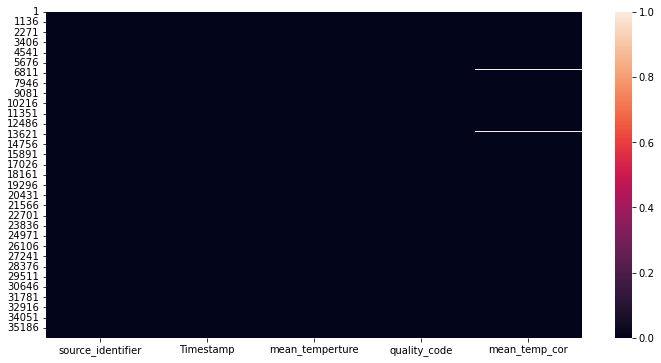

In [12]:
#Check the NaN value distribution with heatmap 

import seaborn as sns 
sns.heatmap(df.isnull())

In [13]:
# Just investigate the rows with NaN values 

df_non_rows = df[df["quality_code"] == 9]

#print(df_non_rows.to_string())

#### Explore the missing data and suggested strategy: 

* 1940 - better discard 
* 1941 - april, june - better discard 
* 1944-10-23 - only one day, clud fill it in 
* 1959 - better discard 
* 1960-01-31, 1960-02-29, 1960-07-31 - could fill in 
* 1965-08-31 - could fill in 
* 1966-01-01 - could fill in 
* 1992-01-10, 1992-01-20 - could fill in
* 2005-03-07 - could fill in
* 2006-05-22, 2006-05-23 - two next to each other - could still fill in 
* 2018-04-07 - 2018-04-10 & 2018-12-18; 2018-12-31 - fill in 
* 2019-01-29; 2019-02-14; 2019-02-17; 2019-03-06; 2019-03-09; 2019-06-11; 2019-10-24; 2019-12-15; 2019-12-15 - fill in 
* 2020-01-06; 2020-10-29; 2020-10-29; 2020-11-17 - fill in 
* 2021-06-03 - fill in 
* 2022-05-01 - 2022-05-31 - drop the whole may in 2002

In [14]:
# Format the dataframe with additional columns for year, month, day
# Set the timestamp as index 

df["year"] = df["Timestamp"].dt.year
df["month"] = df["Timestamp"].dt.month
df["day"] = df['Timestamp'].dt.day
df_time = df.set_index('Timestamp')
df_time.head(3)

,source_identifier,mean_temperture,quality_code,mean_temp_cor,year,month,day
Timestamp,,,,,,,
1923-01-01,105287,3.8,0,3.8,1923,1,1
1923-01-02,105287,2.4,0,2.4,1923,1,2
1923-01-03,105287,0.4,0,0.4,1923,1,3


In [15]:
# Remove the years with many missing values - 1940, 1941, 1959
# Remove the May of 2022, has a lot of missing values and will be used to predict temperature 

df_time.drop(df_time[df_time['year'] == 1940].index, inplace = True)
df_time.drop(df_time[df_time['year'] == 1941].index, inplace = True)
df_time.drop(df_time[df_time['year'] == 1959].index, inplace = True)
df_time.drop(df_time[(df_time['year'] == 2022) & (df_time['month'] == 5)].index, inplace = True)
df_time.isnull().sum()

source_identifier     0
mean_temperture       0
quality_code          0
mean_temp_cor        33
year                  0
month                 0
day                   0
dtype: int64

In [16]:
# df["Timestamp"] =2006-05-22, 2006-05-23 - two next to each other
# Manual backfill and forwardfill

df_time.loc["2006-05-22", "mean_temp_cor"] = df_time.loc["2006-05-21", "mean_temp_cor"]
df_time.loc["2006-05-23", "mean_temp_cor"] = df_time.loc["2006-05-24", "mean_temp_cor"]

df_time.isnull().sum()

source_identifier     0
mean_temperture       0
quality_code          0
mean_temp_cor        31
year                  0
month                 0
day                   0
dtype: int64

In [17]:
# For the other missing values use forwardfill

df_time['mean_temp_cor'].fillna(method='ffill', inplace = True)
df_time.isnull().sum()

source_identifier    0
mean_temperture      0
quality_code         0
mean_temp_cor        0
year                 0
month                0
day                  0
dtype: int64

## Plot the time series

<AxesSubplot:xlabel='month', ylabel='mean_temp_cor'>

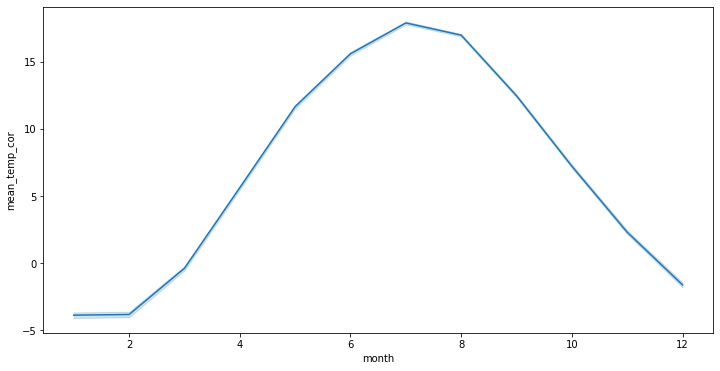

In [18]:
sns.lineplot(data=df_time, x="month", y="mean_temp_cor")

<AxesSubplot:xlabel='year', ylabel='mean_temp_cor'>

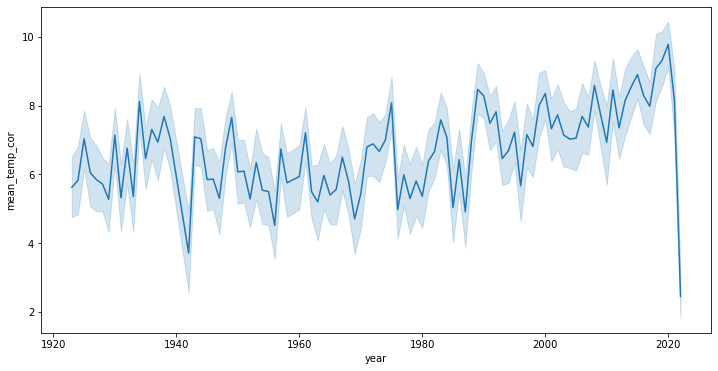

In [19]:
sns.lineplot(data=df_time, x="year", y="mean_temp_cor")
#Due to only first months (winter/beginning of spring) present in 2022, there is a steep drop in average temperature

<AxesSubplot:xlabel='Timestamp', ylabel='mean_temp_cor'>

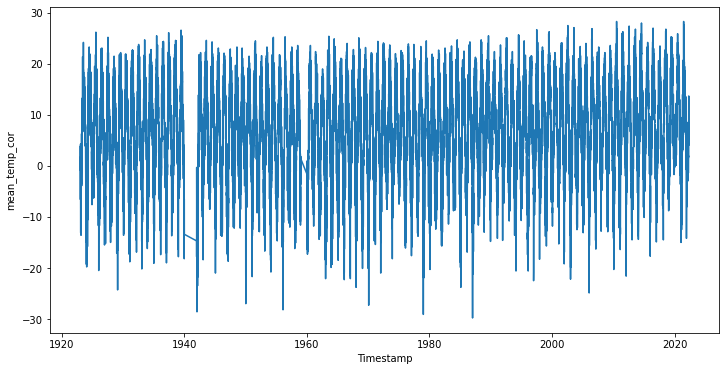

In [20]:
sns.lineplot(data=df_time, x="Timestamp", y="mean_temp_cor")

# Can see the gaps greated from removed years - 1940, 1941 and 1959 

## Select dataset and modeal trend and seasonality

In [21]:
# Limit database for two decades 2001-2021 & 2022 (partial)

df_last20y = df_time.drop(df_time[df_time["year"] < 2001].index)
df_last20y.drop(columns=["mean_temperture", "source_identifier", "quality_code"], inplace = True)
df_last20y.head()

,mean_temp_cor,year,month,day
Timestamp,,,,
2001-01-01,0.4,2001,1,1
2001-01-02,-2.0,2001,1,2
2001-01-03,-1.5,2001,1,3
2001-01-04,0.5,2001,1,4
2001-01-05,0.9,2001,1,5


<AxesSubplot:xlabel='Timestamp', ylabel='mean_temp_cor'>

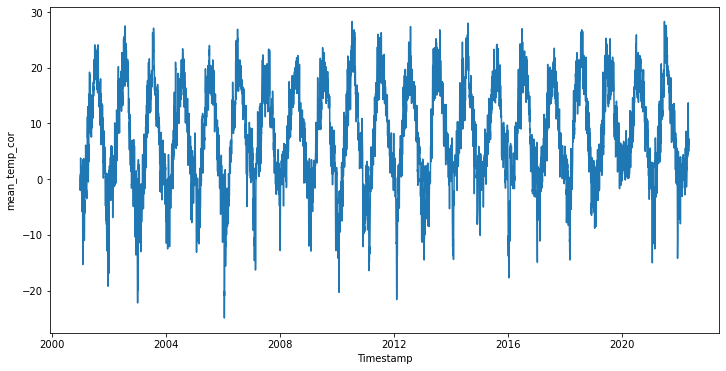

In [22]:
#Plot the time series

sns.lineplot(data=df_last20y, x="Timestamp", y="mean_temp_cor")

In [23]:
# Make a dataframe from 2000 december, can use it later for fillining in the values of lag 

df_2000_dec = df_time.loc[df_time['year'] == 2000]
df_2000_dec = df_2000_dec.loc[df_2000_dec["month"] ==12]
df_2000_dec.drop(columns=["mean_temperture", "source_identifier", "quality_code"], inplace = True)

### Model the trend 

In [24]:
# Add timestep to model the overall trend

df_last20y["timestep"] = range(len(df_last20y))
df_last20y.head()


,mean_temp_cor,year,month,day,timestep
Timestamp,,,,,
2001-01-01,0.4,2001,1,1,0
2001-01-02,-2.0,2001,1,2,1
2001-01-03,-1.5,2001,1,3,2
2001-01-04,0.5,2001,1,4,3
2001-01-05,0.9,2001,1,5,4


In [25]:
df_last20y.to_csv('../Data/df_last20y.csv')

In [26]:
df_last20y.tail()

,mean_temp_cor,year,month,day,timestep
Timestamp,,,,,
2022-04-26,7.3,2022,4,26,7785
2022-04-27,5.0,2022,4,27,7786
2022-04-28,6.3,2022,4,28,7787
2022-04-29,7.0,2022,4,29,7788
2022-04-30,6.4,2022,4,30,7789


In [27]:
# Predict mean temperature dependent on the trend 

#  Isolate X and y 

X_past20y_1 = df_last20y[["timestep"]]
y_past20y_1 = df_last20y[["mean_temp_cor"]]

# Create a linear model 

m_past20y_1 = LinearRegression()

# Fit the model (optimization)

m_past20y_1.fit(X_past20y_1, y_past20y_1)

# Make a prediction 
# Let us create the trend by prediction

df_last20y["trend"] = m_past20y_1.predict(X_past20y_1)

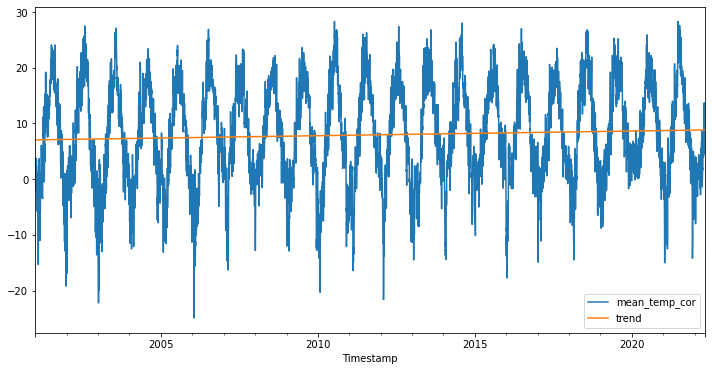

In [28]:
# Make a plot using the trend 

df_last20y[["mean_temp_cor", "trend"]].plot();

In [ ]:
# See a slight increase in the average temperature over the past 20 years ~2°C

In [29]:
# Evaluate the model 
m_past20y_1.score(X_past20y_1, y_past20y_1)

0.003476172946681233

In [ ]:
# As the tempeature variations are quite large, the trend alone is not a good representation of the data 

### Use monthly seasonality to improve model

In [30]:
# Create month categories/dummies 
# Match the index column to the df_last20y column so we can join them 

monthly_dummies = pd.get_dummies(df_last20y.index.month, prefix = "month").set_index(df_last20y.index)

# Join the with the df_last20y

df_last20y_mon = df_last20y.join(monthly_dummies)
df_last20y_mon.head(3)

,mean_temp_cor,year,month,day,timestep,trend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Timestamp,,,,,,,,,,,,,,,,,,
2001-01-01,0.4,2001,1,1,0,7.050889,1,0,0,0,0,0,0,0,0,0,0,0
2001-01-02,-2.0,2001,1,2,1,7.051118,1,0,0,0,0,0,0,0,0,0,0,0
2001-01-03,-1.5,2001,1,3,2,7.051347,1,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# Isolate X and y

X_2 = df_last20y_mon.drop(["mean_temp_cor", "trend"], axis = 1)
y_2 = df_last20y_mon["mean_temp_cor"]

In [32]:
#Define a linear regression model and fit the data 

m_2 = LinearRegression().fit(X_2,y_2)

#Make a prediction 

df_last20y_mon["trend_seasonal"] = m_2.predict(X_2)

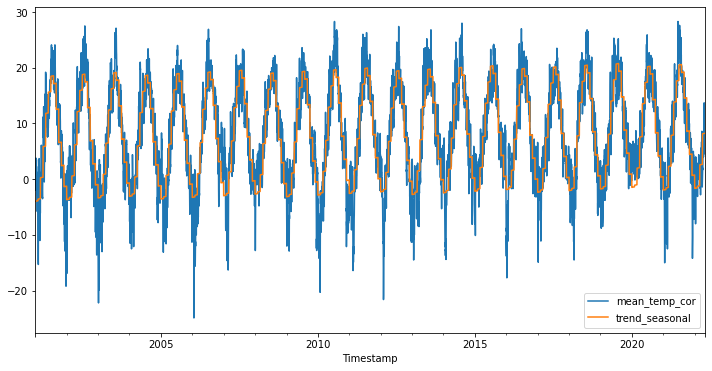

In [33]:
# Plot

df_last20y_mon[["mean_temp_cor", "trend_seasonal"]].plot();

In [34]:
# The model score:
m_2.score(X_2, y_2)

0.7906856445332389

In [ ]:
# Adding the monthly seasonality has improved the overall representation of the data

### Extract the remainder

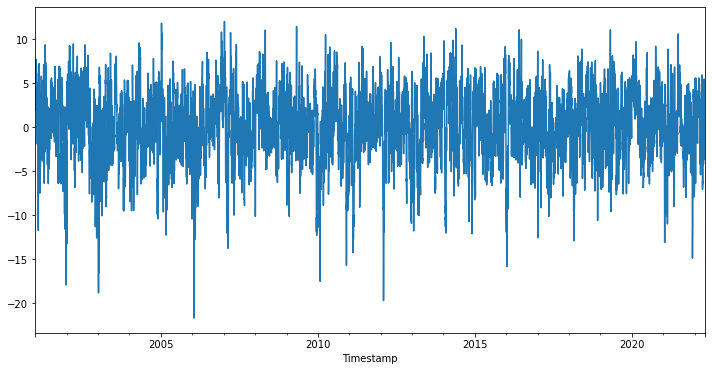

In [35]:
# Obtain the remainder 

df_last20y_mon["remainder"] = df_last20y_mon["mean_temp_cor"] - df_last20y_mon["trend_seasonal"]

# Plot the remainder

df_last20y_mon["remainder"].plot();

In [36]:
# Save it as csv file

df_last20y_mon["remainder"].to_csv("../data/remainder_last20y.csv")

## Improve the fit using remainder 

In [37]:
# Add lag feature
df_last20y_mon["lag1"] = df_last20y_mon["remainder"].shift(1)
df_last20y_mon.head(5)

,mean_temp_cor,year,month,day,timestep,trend,month_1,month_2,month_3,month_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.4,2001,1,1,0,7.050889,1,0,0,0,...,0,0,0,0,0,0,0,-3.964224,4.364224,NaN
2001-01-02,-2.0,2001,1,2,1,7.051118,1,0,0,0,...,0,0,0,0,0,0,0,-3.961042,1.961042,4.364224
2001-01-03,-1.5,2001,1,3,2,7.051347,1,0,0,0,...,0,0,0,0,0,0,0,-3.957860,2.457860,1.961042
2001-01-04,0.5,2001,1,4,3,7.051576,1,0,0,0,...,0,0,0,0,0,0,0,-3.954677,4.454677,2.457860
2001-01-05,0.9,2001,1,5,4,7.051806,1,0,0,0,...,0,0,0,0,0,0,0,-3.951495,4.851495,4.454677


0.8313104082898556


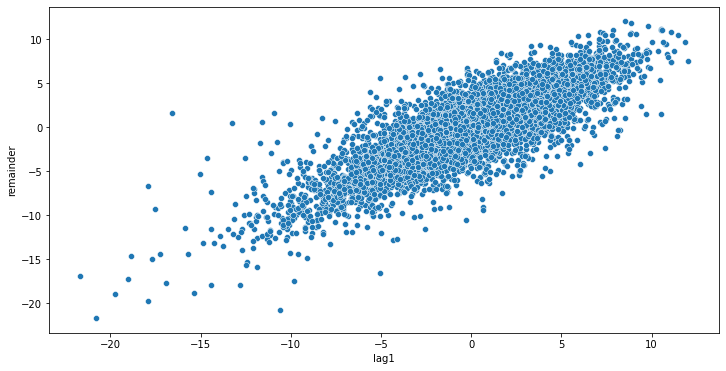

In [38]:
# Inspect correlation 

correlation = df_last20y_mon["remainder"].corr(df_last20y_mon["lag1"])
print(correlation)

sns.scatterplot(x='lag1', y='remainder', data=df_last20y_mon);

# The correlation is good between remainder and lag1

Run an Autoregression (Linear Regression) of lag1 on the remainder

In [39]:
# 1st - drop missing values
df_last20y_mon_adj = df_last20y_mon.drop(index="2001-01-01")

In [40]:
df_last20y_mon_adj.head()

,mean_temp_cor,year,month,day,timestep,trend,month_1,month_2,month_3,month_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-2.0,2001,1,2,1,7.051118,1,0,0,0,...,0,0,0,0,0,0,0,-3.961042,1.961042,4.364224
2001-01-03,-1.5,2001,1,3,2,7.051347,1,0,0,0,...,0,0,0,0,0,0,0,-3.957860,2.457860,1.961042
2001-01-04,0.5,2001,1,4,3,7.051576,1,0,0,0,...,0,0,0,0,0,0,0,-3.954677,4.454677,2.457860
2001-01-05,0.9,2001,1,5,4,7.051806,1,0,0,0,...,0,0,0,0,0,0,0,-3.951495,4.851495,4.454677
2001-01-06,0.6,2001,1,6,5,7.052035,1,0,0,0,...,0,0,0,0,0,0,0,-3.948312,4.548312,4.851495


In [41]:
# Assign X and y
X_3 = df_last20y_mon_adj[['lag1']]
y_3 = df_last20y_mon_adj['remainder']

# Create and fit the model
m_rem = LinearRegression()
m_rem.fit(X_3, y_3)

# Create predictions
df_last20y_mon_adj['predictions_ar1'] = m_rem.predict(X_3)
df_last20y_mon_adj.head()

,mean_temp_cor,year,month,day,timestep,trend,month_1,month_2,month_3,month_4,...,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_ar1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-2.0,2001,1,2,1,7.051118,1,0,0,0,...,0,0,0,0,0,0,-3.961042,1.961042,4.364224,3.627041
2001-01-03,-1.5,2001,1,3,2,7.051347,1,0,0,0,...,0,0,0,0,0,0,-3.957860,2.457860,1.961042,1.629376
2001-01-04,0.5,2001,1,4,3,7.051576,1,0,0,0,...,0,0,0,0,0,0,-3.954677,4.454677,2.457860,2.042360
2001-01-05,0.9,2001,1,5,4,7.051806,1,0,0,0,...,0,0,0,0,0,0,-3.951495,4.851495,4.454677,3.702231
2001-01-06,0.6,2001,1,6,5,7.052035,1,0,0,0,...,0,0,0,0,0,0,-3.948312,4.548312,4.851495,4.032088


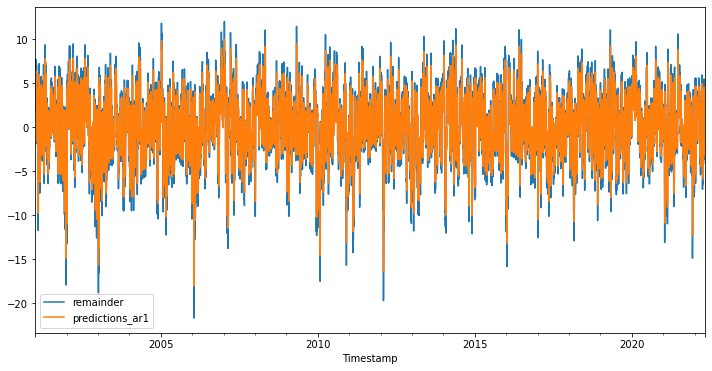

In [42]:
# Plot the original remainder and the prediction
df_last20y_mon_adj[["remainder", "predictions_ar1"]].plot();

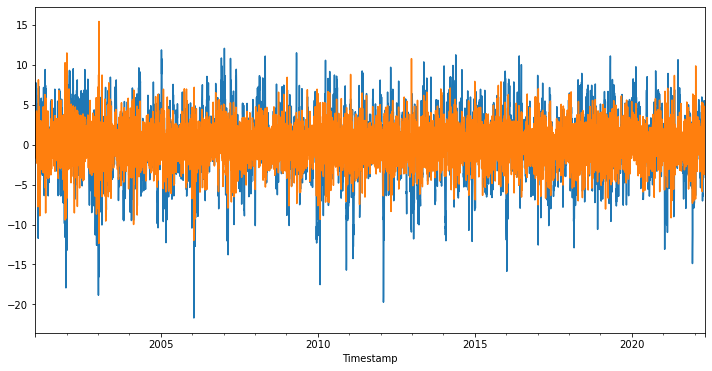

In [43]:
# Is the remainder prediction error smaller than the remainder?
df_last20y_mon_adj['remainder'].plot();
(df_last20y_mon_adj['remainder'] - df_last20y_mon_adj['predictions_ar1']).plot();

# From the plot - just slighlty 

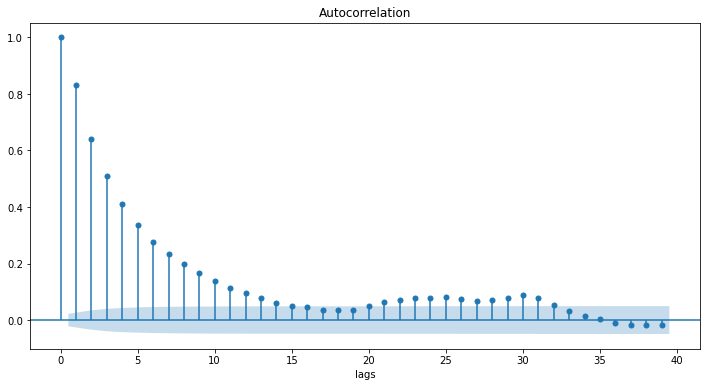

In [44]:
# Check with autocorrelation 

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_last20y_mon_adj['remainder'])
plt.xlabel('lags');

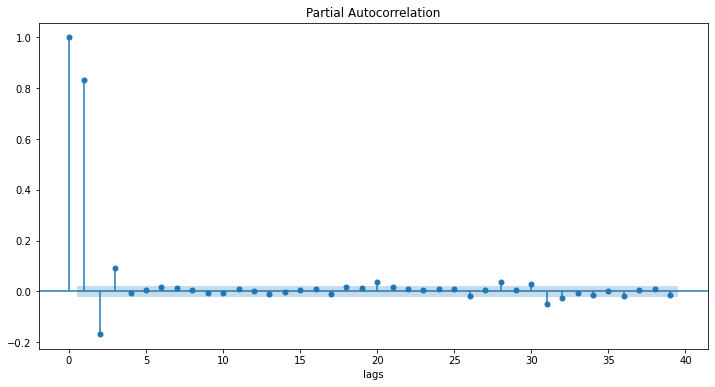

In [45]:
# Check for partial autocorrelation 

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_last20y_mon_adj['remainder'])
plt.xlabel('lags');

In [ ]:
# Only one lag is needed. 

In [47]:
# Box-Jenkins-Methodology

from statsmodels.tsa.ar_model import ar_select_order

lags_order = ar_select_order(df_last20y_mon_adj['remainder'], maxlag=14)
lags_order.ar_lags

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


array([1, 2, 3])

In [48]:
lags_order.aic

{(1, 2, 3): 1.562595038603386,
 (1, 2, 3, 4): 1.5628156607600703,
 (1, 2, 3, 4, 5): 1.5630277504677696,
 (1, 2, 3, 4, 5, 6): 1.5630423313889281,
 (1, 2, 3, 4, 5, 6, 7): 1.5631333606435824,
 (1, 2, 3, 4, 5, 6, 7, 8): 1.5633415126132622,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 1.5635473956846915,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 1.5637280092882868,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 1.5638642538833634,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 1.5641212267279694,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13): 1.564281143475827,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14): 1.5645355223549027,
 (1, 2): 1.5709377353139788,
 (1,): 1.5994278717105677,
 0: 2.7726429543899087}

In [120]:
# Three lags would be the best according to Box-Jenkins-Methodology

## ARIMA (Autoregressive-Integrated-Moving-Average Model)

In [49]:
from statsmodels.tsa.arima.model import ARIMA

In [50]:
arima = ARIMA(endog= df_last20y_mon_adj['remainder'], order = (1,0,3)).fit()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [51]:
# Make a prediction on remainder using auto regressive integral moving average modeling
# That is, model linear regession on errors/residues of the past 

df_last20y_mon_adj['arima_prediction'] = arima.predict()

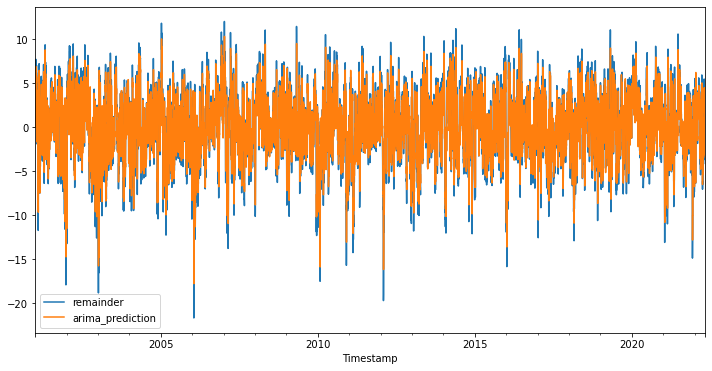

In [52]:
df_last20y_mon_adj[["remainder", "arima_prediction"]].plot();

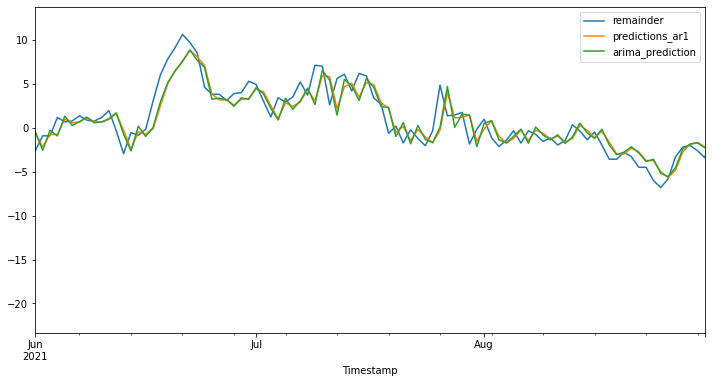

In [53]:
df_last20y_mon_adj[["remainder","predictions_ar1" ,"arima_prediction"]].plot(xlim=("2021-06-01","2021-08-31"));

In [ ]:
# ARIMA and AR models seem to strongly overlap 

In [54]:
#Evaluate the absolute errors for AR and ARIMA

from sklearn.metrics import mean_absolute_error

ar_error = round(mean_absolute_error(df_last20y_mon_adj['remainder'], df_last20y_mon_adj['predictions_ar1']),2)
arima_error = round(mean_absolute_error(df_last20y_mon_adj['remainder'], df_last20y_mon_adj['arima_prediction']),2)

f'Mean absolute error for Auto Regression: {ar_error} and it was improved to {arima_error} with ARIMA'

'Mean absolute error for Auto Regression: 1.67 and it was improved to 1.65 with ARIMA'

In [ ]:
# ARIMA model improved the performene only very slighlty

In [55]:
# Check with full model 

df_last20y_mon_adj['full_pred_arima'] = df_last20y_mon_adj['trend_seasonal']+ df_last20y_mon_adj['arima_prediction']

df_last20y_mon_adj['full_pred_ar'] = df_last20y_mon_adj['trend_seasonal']+ df_last20y_mon_adj['predictions_ar1']


In [56]:
# Compare to base model 

base_model_error = round(mean_absolute_error(df_last20y_mon_adj['mean_temp_cor'], df_last20y_mon_adj['trend_seasonal']), 2)
ar_error = round(mean_absolute_error(df_last20y_mon_adj['mean_temp_cor'], df_last20y_mon_adj['full_pred_ar']), 2)
arima_error = round(mean_absolute_error(df_last20y_mon_adj['mean_temp_cor'], df_last20y_mon_adj['full_pred_arima']), 2)

f'Mean absolute error for the base model {base_model_error}, the  Auto Regression: {ar_error} and  ARIMA {arima_error}'


'Mean absolute error for the base model 3.14, the  Auto Regression: 1.67 and  ARIMA 1.65'

In [ ]:
# Using Auto Regression did imrpove the model, however there was no large improvement using ARIMA 

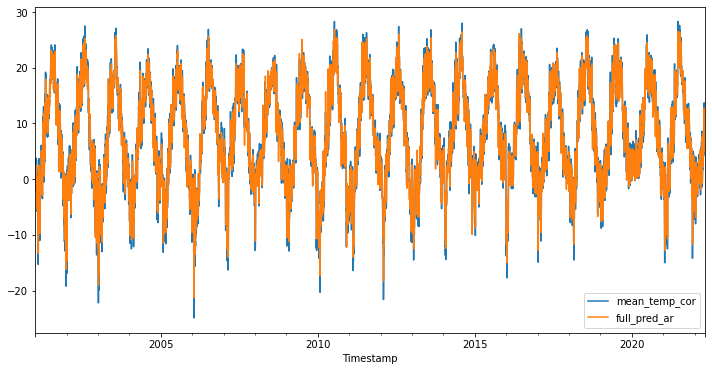

In [57]:
df_last20y_mon_adj[["mean_temp_cor", "full_pred_ar"]].plot();

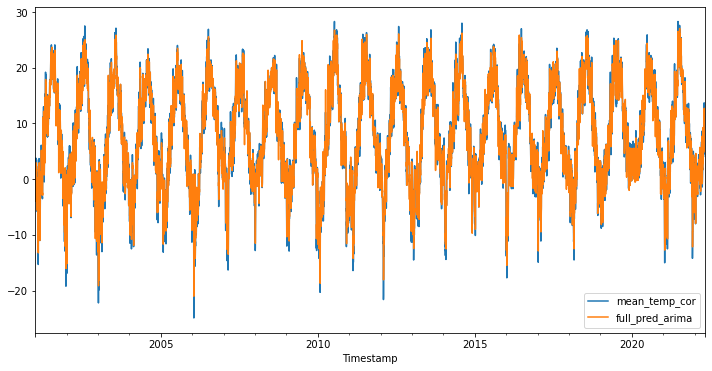

In [58]:
df_last20y_mon_adj[["mean_temp_cor", "full_pred_arima"]].plot();

## Evaluation of forecast using train/test set 

In [59]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [136]:
# Create a splitter 

ts_split = TimeSeriesSplit(n_splits=5)

In [153]:
# Apply split on X_2 and y_2 (from AR model)

time_series_split = ts_split.split(X_2, y_2)

In [154]:
# Apply cross validation on the dataset and get the evaluation 

result = cross_val_score(estimator=m_2, X=X_2, y=y_2, cv=time_series_split)

print("The score of 5 training sets:")
print(result, "\n")
print("The mean score:")
print(round(result.mean(),3))

The score of 5 training sets:
[0.68235869 0.8171205  0.76214803 0.79973632 0.75577145] 

The mean score:
0.763


## Evaluate the prediction of model on unseen data

In [60]:
dates_test= ["2022-05-01", "2022-05-02", "2022-05-03", "2022-05-04", "2022-05-05", "2022-05-06", "2022-05-07"]
temp_test = [5.8, 8, 7.3, 6, 7.8, 12.5, 10.6]

df_test =pd.DataFrame(list(zip(dates_test, temp_test)), columns =['Date', 'mean_temp_cor'])
df_test
df_test['Timestamp']=pd.to_datetime(df_test['Date'])
df_test["year"] = df_test["Timestamp"].dt.year
df_test["month"] = df_test["Timestamp"].dt.month
df_test["day"] = df_test['Timestamp'].dt.day

df_test = df_test.set_index('Timestamp')

df_test.drop(["Date"], axis =1)

,mean_temp_cor,year,month,day
Timestamp,,,,
2022-05-01,5.8,2022,5,1
2022-05-02,8.0,2022,5,2
2022-05-03,7.3,2022,5,3
2022-05-04,6.0,2022,5,4
2022-05-05,7.8,2022,5,5
2022-05-06,12.5,2022,5,6
2022-05-07,10.6,2022,5,7


In [61]:
df_test["timestep"] = [7790, 7791, 7792, 7793, 7794, 7795, 7796]

In [62]:
monthly_dummies_test = pd.get_dummies(df_test.index.month, prefix = "month").set_index(df_test.index)

In [63]:
lst = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
monthly_dummies_mock_1 =  pd.DataFrame(lst, columns =['month_1', 'month_2', 'month_3', 'month_4']).set_index(df_test.index)

lst_2 = [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
monthly_dummies_mock_2 =  pd.DataFrame(lst_2, columns =['month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month12']).set_index(df_test.index)

monthly_dummies_test_full_1 =monthly_dummies_mock_1.join(monthly_dummies_test)
monthly_dummies_test_full =monthly_dummies_test_full_1.join(monthly_dummies_mock_2)
monthly_dummies_test_full

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month12
Timestamp,,,,,,,,,,,,
2022-05-01,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-02,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-03,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-04,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-05,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-06,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-07,0,0,0,0,1,0,0,0,0,0,0,0


In [64]:
# Join the with the df_last20y

df_test_mon = df_test.join(monthly_dummies_test_full)
df_test_mon.drop(["Date"], axis =1, inplace =True)
df_test_mon.head(3)

,mean_temp_cor,year,month,day,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month12
Timestamp,,,,,,,,,,,,,,,,,
2022-05-01,5.8,2022,5,1,7790,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-02,8.0,2022,5,2,7791,0,0,0,0,1,0,0,0,0,0,0,0
2022-05-03,7.3,2022,5,3,7792,0,0,0,0,1,0,0,0,0,0,0,0


In [65]:
# Define the test set 

X_test = df_test_mon.drop("mean_temp_cor", axis=1)

#Make a prediction 

df_test_mon["trend_seasonal"] = m_2.predict(X_test)


df_test_mon

,mean_temp_cor,year,month,day,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month12,trend_seasonal
Timestamp,,,,,,,,,,,,,,,,,,
2022-05-01,5.8,2022,5,1,7790,0,0,0,0,1,0,0,0,0,0,0,0,14.107599
2022-05-02,8.0,2022,5,2,7791,0,0,0,0,1,0,0,0,0,0,0,0,14.110782
2022-05-03,7.3,2022,5,3,7792,0,0,0,0,1,0,0,0,0,0,0,0,14.113964
2022-05-04,6.0,2022,5,4,7793,0,0,0,0,1,0,0,0,0,0,0,0,14.117146
2022-05-05,7.8,2022,5,5,7794,0,0,0,0,1,0,0,0,0,0,0,0,14.120329
2022-05-06,12.5,2022,5,6,7795,0,0,0,0,1,0,0,0,0,0,0,0,14.123511
2022-05-07,10.6,2022,5,7,7796,0,0,0,0,1,0,0,0,0,0,0,0,14.126694


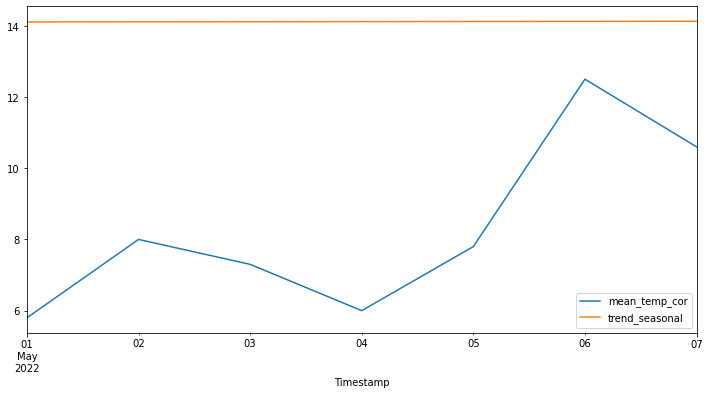

In [66]:
#Plot the values 

df_test_mon[["mean_temp_cor", "trend_seasonal"]].plot();

### Ad AR 

In [ ]:
# Take the last week for testing. Train AR and test on last week. 

In [68]:
# Extract the remainder 

df_test_mon["remainder"]=df_test_mon["mean_temp_cor"]-df_test_mon["trend_seasonal"]

# Add lag feature 

df_test_mon["lag1"] = df_test_mon["remainder"].shift(1)
df_test_mon.loc["2022-05-01", "lag1"] = df_last20y_mon.loc["2022-04-30", "remainder"]

In [69]:
df_test_mon

,mean_temp_cor,year,month,day,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month12,trend_seasonal,remainder,lag1
Timestamp,,,,,,,,,,,,,,,,,,,,
2022-05-01,5.8,2022,5,1,7790,0,0,0,0,1,0,0,0,0,0,0,0,14.107599,-8.307599,-1.834991
2022-05-02,8.0,2022,5,2,7791,0,0,0,0,1,0,0,0,0,0,0,0,14.110782,-6.110782,-8.307599
2022-05-03,7.3,2022,5,3,7792,0,0,0,0,1,0,0,0,0,0,0,0,14.113964,-6.813964,-6.110782
2022-05-04,6.0,2022,5,4,7793,0,0,0,0,1,0,0,0,0,0,0,0,14.117146,-8.117146,-6.813964
2022-05-05,7.8,2022,5,5,7794,0,0,0,0,1,0,0,0,0,0,0,0,14.120329,-6.320329,-8.117146
2022-05-06,12.5,2022,5,6,7795,0,0,0,0,1,0,0,0,0,0,0,0,14.123511,-1.623511,-6.320329
2022-05-07,10.6,2022,5,7,7796,0,0,0,0,1,0,0,0,0,0,0,0,14.126694,-3.526694,-1.623511


In [70]:
# Define X nd y 

X_AR_test = df_test_mon[['lag1']]
y_AR_test = df_test_mon['remainder']

# Use the model (m_rem) that is trained on full dataset of past 20 years (X_3, y_3)

# Create predictions
df_test_mon['predictions_ar1'] = m_rem.predict(X_AR_test)

#Check with full model 
df_test_mon['full_pred_ar'] = df_test_mon['trend_seasonal']+ df_test_mon['predictions_ar1']

#Evaluate
ar_error_test = round(mean_absolute_error(df_test_mon['mean_temp_cor'], df_test_mon['full_pred_ar']), 2)

print("Score:", ar_error_test)

Score: 2.57


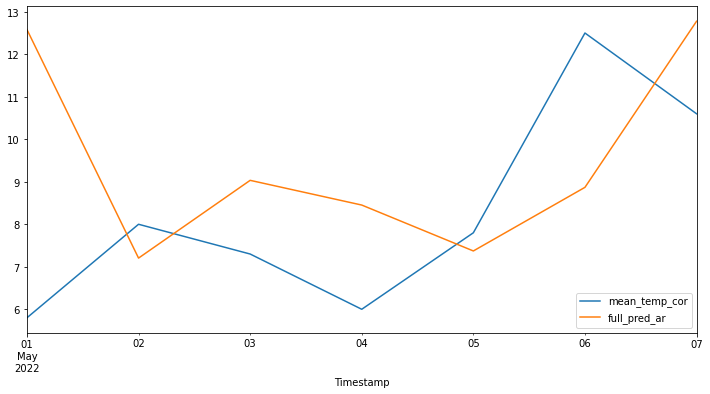

In [71]:
# Plot 

df_test_mon[["mean_temp_cor", "full_pred_ar"]].plot();

In [72]:
df_test_mon

,mean_temp_cor,year,month,day,timestep,month_1,month_2,month_3,month_4,month_5,...,month_8,month_9,month_10,month_11,month12,trend_seasonal,remainder,lag1,predictions_ar1,full_pred_ar
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-05-01,5.8,2022,5,1,7790,0,0,0,0,1,...,0,0,0,0,0,14.107599,-8.307599,-1.834991,-1.526107,12.581492
2022-05-02,8.0,2022,5,2,7791,0,0,0,0,1,...,0,0,0,0,0,14.110782,-6.110782,-8.307599,-6.906515,7.204266
2022-05-03,7.3,2022,5,3,7792,0,0,0,0,1,...,0,0,0,0,0,14.113964,-6.813964,-6.110782,-5.080393,9.033571
2022-05-04,6.0,2022,5,4,7793,0,0,0,0,1,...,0,0,0,0,0,14.117146,-8.117146,-6.813964,-5.664919,8.452227
2022-05-05,7.8,2022,5,5,7794,0,0,0,0,1,...,0,0,0,0,0,14.120329,-6.320329,-8.117146,-6.748200,7.372129
2022-05-06,12.5,2022,5,6,7795,0,0,0,0,1,...,0,0,0,0,0,14.123511,-1.623511,-6.320329,-5.254581,8.868930
2022-05-07,10.6,2022,5,7,7796,0,0,0,0,1,...,0,0,0,0,0,14.126694,-3.526694,-1.623511,-1.350313,12.776381
